## Szkieletyzacja (skeletonization)

Szkieletyzacja polega na stopniowym usuwaniu pikseli z krawędzi obiektu, aż pozostanie jego szkielet — cienka linia biegnąca wzdłuż „środka” obiektu.
Szkielet zachowuje:
* kształt (ogólny zarys),
* topologię (połączenia między częściami),
* długość i układ rozgałęzień.

Piksele z brzegu obiektu są usuwane iteracyjnie, ale tylko wtedy, gdy:
* nie naruszają spójności obiektu,
* nie rozdzielają go na kilka części.

## Pocienianie (thinning)

Pocienianie to proces redukcji szerokości obiektu binarnego do linii o grubości jednego piksela, bez koniecznego zachowania osi symetrii jak w szkieletyzacji.
Działa poprzez stopniowe „ścienianie” kształtu z krawędzi, aż obiekt stanie się maksymalnie cienki.

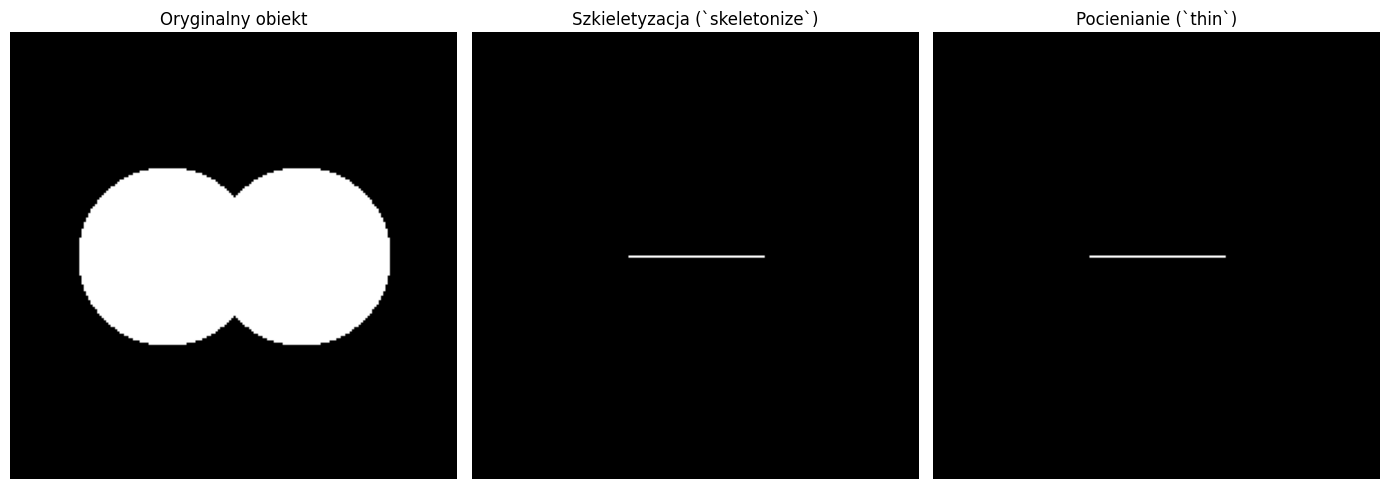

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import skeletonize, thin
from skimage.draw import disk
from skimage.util import invert

# Utwórz prosty obiekt (np. dwa połączone okręgi)
image = np.zeros((200, 200), dtype=bool)
rr, cc = disk((100, 70), 40)
image[rr, cc] = 1
rr, cc = disk((100, 130), 40)
image[rr, cc] = 1

# Szkieletyzacja i pocienianie
skeleton = skeletonize(image)
thinned = thin(image)

# Wizualizacja
fig, ax = plt.subplots(1, 3, figsize=(14, 5))
ax[0].imshow(image, cmap='gray')
ax[0].set_title("Oryginalny obiekt")

ax[1].imshow(skeleton, cmap='gray')
ax[1].set_title("Szkieletyzacja (`skeletonize`)")

ax[2].imshow(thinned, cmap='gray')
ax[2].set_title("Pocienianie (`thin`)")

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

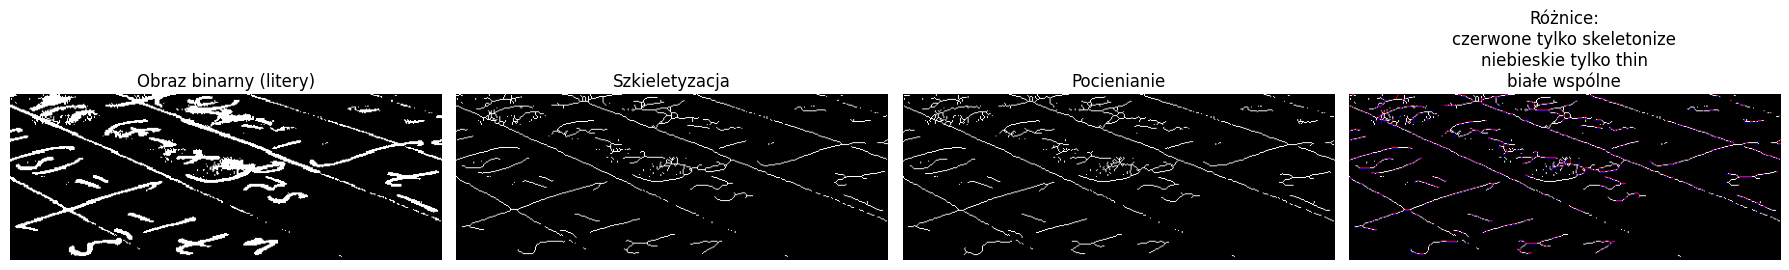

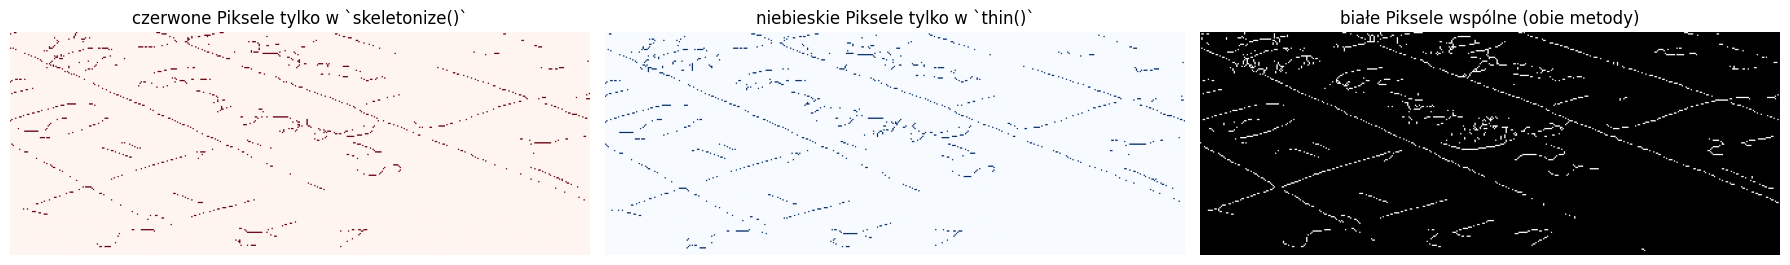

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color
from skimage.filters import threshold_otsu
from skimage.morphology import skeletonize, thin

# Wczytaj obraz tekstu
img = data.text()

# Sprawdź czy RGB czy już 2D
if img.ndim == 3:
    gray = color.rgb2gray(img)
else:
    gray = img.astype(np.float64)
    if gray.max() > 1.0:
        gray /= gray.max()

# Binarizacja
th = threshold_otsu(gray)
binary = gray < th
binary = binary.astype(bool)

# Szkieletyzacja i pocienianie
skel = skeletonize(binary)
thin_img = thin(binary)

# Oblicz różnice
only_skel = np.logical_and(skel, np.logical_not(thin_img))   # czerwone
only_thin = np.logical_and(thin_img, np.logical_not(skel))   # niebieskie
both = np.logical_and(skel, thin_img)                        # wspólne (białe)

# Utwórz kolorowy obraz różnic
diff_rgb = np.zeros((*binary.shape, 3))
diff_rgb[..., 0] = only_skel      # red channel
diff_rgb[..., 2] = only_thin      # blue channel
diff_rgb[..., 0:3] += both[..., None]  # dodaj wspólne (biały)

# --- Główne porównanie (4 obrazy) ---
fig, ax = plt.subplots(1, 4, figsize=(18, 5))
ax[0].imshow(binary, cmap='gray')
ax[0].set_title("Obraz binarny (litery)")

ax[1].imshow(skel, cmap='gray')
ax[1].set_title("Szkieletyzacja")

ax[2].imshow(thin_img, cmap='gray')
ax[2].set_title("Pocienianie")

ax[3].imshow(diff_rgb)
ax[3].set_title("Różnice:\nczerwone tylko skeletonize\nniebieskie tylko thin\nbiałe wspólne")

for a in ax:
    a.axis('off')
plt.tight_layout()
plt.show()

# --- Dodatkowe trzy obrazy osobno ---
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(only_skel, cmap='Reds')
ax[0].set_title("czerwone Piksele tylko w `skeletonize()`")

ax[1].imshow(only_thin, cmap='Blues')
ax[1].set_title("niebieskie Piksele tylko w `thin()`")

ax[2].imshow(both, cmap='gray')
ax[2].set_title("białe Piksele wspólne (obie metody)")

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

* Czerwony - Piksele obecne tylko w skeletonize - Ta metoda zostawia nieco „grubsze” fragmenty i rozgałęzienia.
* Niebieski	- Piksele obecne tylko w thin	Pocienianie usuwa więcej pikseli – daje cieńszy, jednolity szkielet.
* Biały	- Piksele wspólne	To „rdzeń” kształtu – wspólna oś uznana przez obie metody.

## Przycinanie (z ang. Pruning) to proces usuwania krótkich, nieistotnych gałązek ze szkieletu obiektu binarnego.
Celem tej operacji jest oczyszczenie szkieletu z drobnych odgałęzień, które powstały w wyniku:

* szumów w obrazie,
* niejednorodnego oświetlenia,
* nieidealnej segmentacji lub binarizacji.

Metody przycinania

* Iteracyjne usuwanie końcówek - najprostsza metoda: w każdej iteracji usuwa się piksele końcowe (z jednym sąsiadem). Po kilku iteracjach znikają krótkie odnogi, ale główny kształt zostaje zachowany.

* Pruning oparty na długości gałęzi. Wykrywa wszystkie gałęzie i mierzy ich długość (np. przez przeszukiwanie grafu). Usuwa tylko te, których długość < ustalonego progu (np. 10 pikseli).

* Pruning morfologiczny - Wykorzystuje operacje morfologiczne (np. hit-or-miss) do usuwania specyficznych wzorców końcówek.

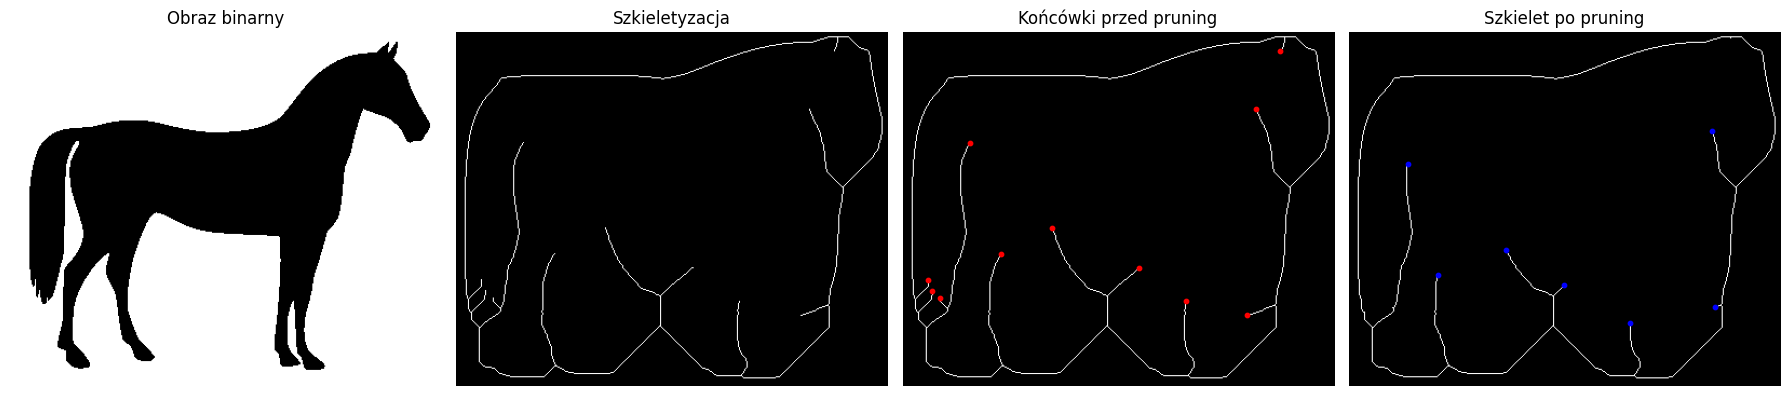

Piksele szkieletu (przed): 1823
Piksele szkieletu (po)   : 1624
Końcówki (przed)         : 11
Końcówki (po)            : 7


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from skimage import data, color
from skimage.filters import threshold_otsu
from skimage.morphology import skeletonize, remove_small_objects

# --------- 0) Pomocnicze: bezpieczne przygotowanie obrazu binarnego ---------
def to_binary(img):
    """Zwraca obraz binarny (bool) niezależnie od formatu wejścia."""
    if img.dtype == bool and img.ndim == 2:
        return img
    if img.ndim == 3:   # RGB -> gray
        gray = color.rgb2gray(img)
    else:               # już 2D
        gray = img.astype(float)
        if gray.max() > 1.0:  # unormuj jeśli trzeba
            gray /= gray.max()
    th = threshold_otsu(gray)
    return (gray < th)  # ciemne obiekty = True

# Dane i binarizacja
img = data.horse()              # 2D (często bool)
binary = to_binary(img)
binary = remove_small_objects(binary, 64)

# Szkieletyzacja
skel = skeletonize(binary)

# Końcówki i pruning
def find_endpoints(skel_bool):
    """Zwraca maskę końcówek (pikseli z 1 sąsiadem w 8-sąsiedztwie)."""
    # 10 dla centrum, 1 dla sąsiadów -> 10 + 1 = 11 oznacza końcówkę
    kernel = np.array([[1,1,1],
                       [1,10,1],
                       [1,1,1]])
    conv = convolve(skel_bool.astype(np.uint8), kernel, mode='constant', cval=0)
    return conv == 11

def prune_skeleton(skel_bool, max_len=15):
    """
    Iteracyjnie usuwa końcówki do zadanej długości gałązki (max_len w pikselach).
    Każda iteracja odcina 1 piksel na końcu gałęzi.
    """
    pruned = skel_bool.copy()
    for _ in range(max_len):
        endpoints = find_endpoints(pruned)
        # zatrzymaj, gdy nie ma już krótkich końcówek
        if not endpoints.any():
            break
        pruned = np.logical_and(pruned, ~endpoints)
    return pruned

pruned = prune_skeleton(skel, max_len=20)

# Wizualizacja: oryginał, szkielet, końcówki, pruning
endpoints_before = find_endpoints(skel)
endpoints_after  = find_endpoints(pruned)

fig, ax = plt.subplots(1, 4, figsize=(18, 5))
ax[0].imshow(binary, cmap='gray'); ax[0].set_title("Obraz binarny"); ax[0].axis('off')
ax[1].imshow(skel, cmap='gray');   ax[1].set_title("Szkieletyzacja"); ax[1].axis('off')

# nałóż końcówki przed pruning (czerwone)
ax[2].imshow(skel, cmap='gray')
y, x = np.where(endpoints_before)
ax[2].scatter(x, y, s=10, c='r')
ax[2].set_title("Końcówki przed pruning"); ax[2].axis('off')

# szkielet po pruning + końcówki po (niebieskie)
ax[3].imshow(pruned, cmap='gray')
y2, x2 = np.where(endpoints_after)
ax[3].scatter(x2, y2, s=10, c='b')
ax[3].set_title("Szkielet po pruning"); ax[3].axis('off')

plt.tight_layout()
plt.show()

# Prosta statystyka
print("Piksele szkieletu (przed):", int(skel.sum()))
print("Piksele szkieletu (po)   :", int(pruned.sum()))
print("Końcówki (przed)         :", int(endpoints_before.sum()))
print("Końcówki (po)            :", int(endpoints_after.sum()))

# Zadanie 1. Analiza układu naczyń krwionośnych (lub dróg) z wykorzystaniem szkieletyzacji

Cel:
Zastosować szkieletyzację do analizy i modelowania rozgałęzionej struktury obiektów — takich jak naczynia krwionośne, korzenie roślin, sieci drogowe lub linie pisma.
Celem jest uzyskanie uproszczonej reprezentacji struktury (szkieletu), która zachowuje topologię, umożliwia pomiar długości i rozgałęzień.

Wyobraź sobie, że jesteś inżynierem biomedycznym analizującym zdjęcia mikroskopowe naczyń krwionośnych. Obraz jest binarny (ciemne naczynia na jasnym tle). Chcesz automatycznie:

* uzyskać szkielet naczyń,
* obliczyć łączną długość naczyń,
* określić liczbę rozgałęzień i końcówek.

Podobne podejście można wykorzystać np. w analizie:

* sieci dróg z obrazów satelitarnych,
* struktur roślinnych (korzeni, liści),
* połączeń ścieżek w układach scalonych.


# Kolejne kroki

Wczytaj obraz (np. mikroskopowy obraz naczyń lub sieć dróg — można użyć data.retina() lub własnego zdjęcia).
Jeśli obraz jest kolorowy — przekształć go do skali szarości.

1. Wykonaj progowanie (np. metodą Otsu), aby uzyskać obraz binarny przedstawiający strukturę obiektu.

2. Wyczyść obraz – usuń małe obiekty i zakłócenia (remove_small_objects, closing, opening).

3. Zastosuj szkieletyzację (skeletonize) do uzyskania osi struktur.

4. Oblicz cechy geometryczne:

* liczbę końcówek szkieletu (punkty z jednym sąsiadem),
* liczbę rozgałęzień (punkty z więcej niż dwoma sąsiadami).

Koncepcja cech geometrycznych szkieletu:
Każdy piksel w szkielecie ma pewną liczbę sąsiadów (8-sąsiedztwo):
* Końcówka (endpoint): piksel, który ma dokładnie jednego sąsiada.
→ Jest to koniec gałęzi szkieletu.
* Rozgałęzienie (branch point): piksel, który ma więcej niż dwóch sąsiadów.→ W tym miejscu łączą się lub rozdzielają gałęzie struktury.

Wizualizuj wynik:

* oryginalny obraz,
* obraz binarny,
* szkielet

In [4]:
from skimage.color import rgb2gray
from skimage.exposure import equalize_hist

def show_images(images, titles, cmaps=None):
    fig, axes = plt.subplots(1, len(images))
    fig.set_size_inches(5*len(images), 5)

    for ax, im, tt, cm in zip(np.atleast_1d(axes), images, titles, cmaps):
        ax.imshow(im, cmap=cm)
        ax.set_title(tt)
        ax.axis('off')

    plt.show()

### Wczytanie obrazu

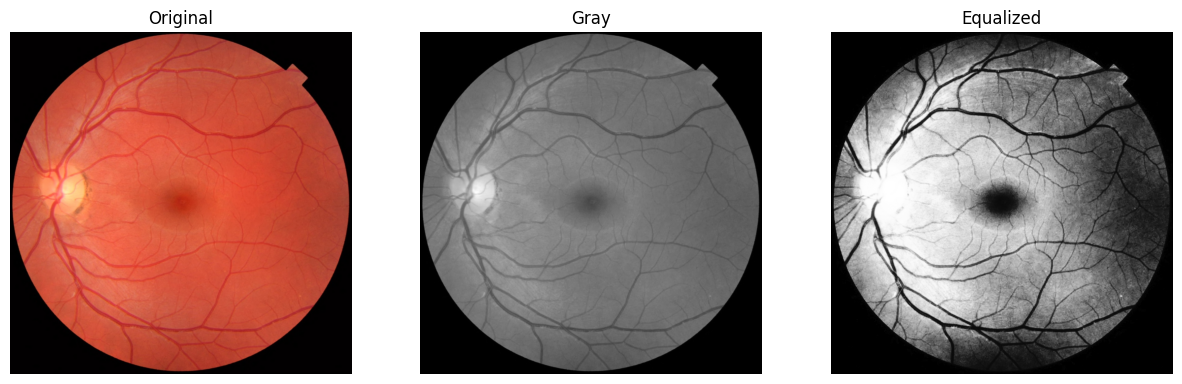

In [5]:
retina = data.retina()
retina_gray = rgb2gray(retina)
retina_equalized = equalize_hist(retina_gray)

show_images(
    [retina, retina_gray, retina_equalized],
    ["Original", "Gray", "Equalized"],
    [None, "gray", "gray"]
)

### Progowawnie

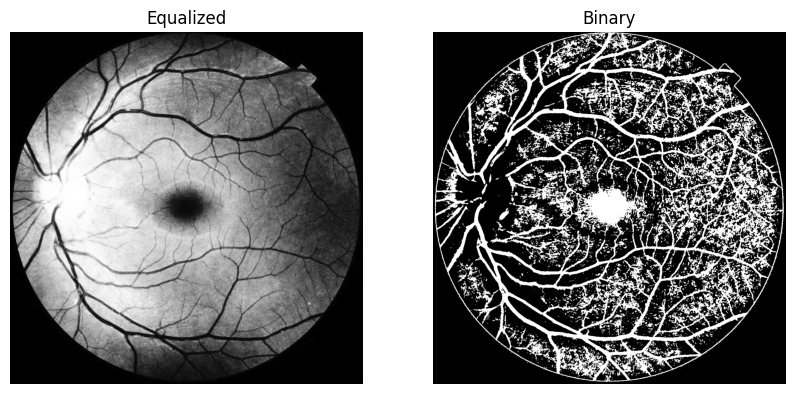

In [6]:
from skimage.filters import threshold_local

retina_threshold_mask = threshold_local(retina_equalized, block_size=151)
retina_binary = retina_equalized < retina_threshold_mask

eye_threshold = .23
eye_mask = retina_equalized > eye_threshold

retina_binary = retina_binary & eye_mask

show_images(
    [retina_equalized, retina_binary],
    ["Equalized", "Binary"],
    ["gray", "gray"]
)

### Czyszczenie obrazu

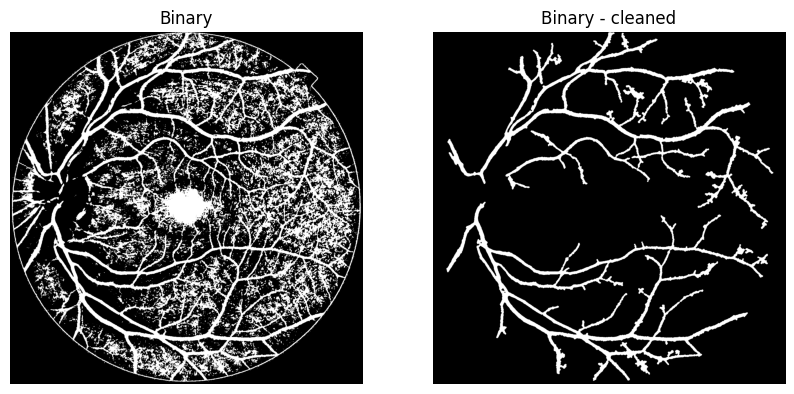

In [7]:
from skimage.morphology import binary_opening, binary_closing, disk, remove_small_objects, remove_small_holes, label

retina_cleaned = binary_opening(retina_binary, disk(3))
retina_cleaned = remove_small_objects(retina_cleaned, min_size=256)
retina_cleaned = binary_closing(retina_cleaned, disk(2))
retina_cleaned = remove_small_objects(retina_cleaned, min_size=8192)
# remove the middle thingamajig
labeled = label(retina_cleaned)
retina_cleaned = np.where(labeled == 2, 0, retina_cleaned)

show_images(
    [retina_binary, retina_cleaned],
    ["Binary", "Binary - cleaned"],
    ["gray", "gray"]
)

### Szkieletyzacja

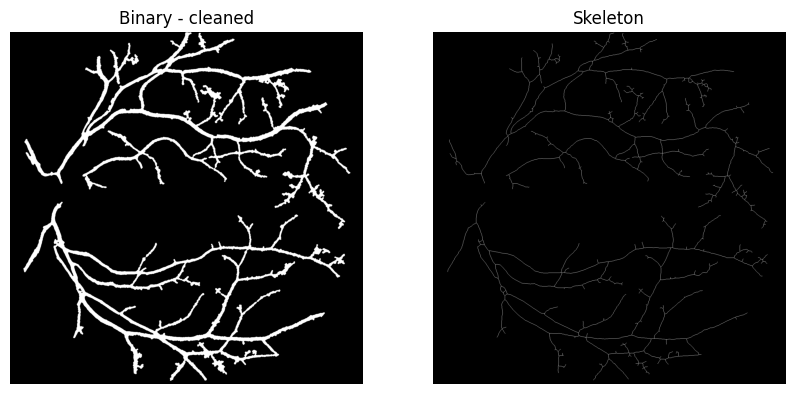

In [8]:
retina_skeleton = skeletonize(retina_cleaned)

show_images(
    [retina_cleaned, retina_skeleton],
    ["Binary - cleaned", "Skeleton"],
    ["gray", "gray"]
)

### Cechy geometryczne

In [9]:
def get_ends(skeleton):
    kernel = np.ones((3,3))
    kernel[1,1] = 10
    return convolve(skeleton.astype(np.int8), kernel, mode="constant") == 11

def get_splits(skeleton):
    kernel = np.ones((3,3))
    kernel[1,1] = 10
    return convolve(skeleton.astype(np.int8), kernel, mode="constant") > 12

Końcówki: 230
Rozgałęzienia: 832


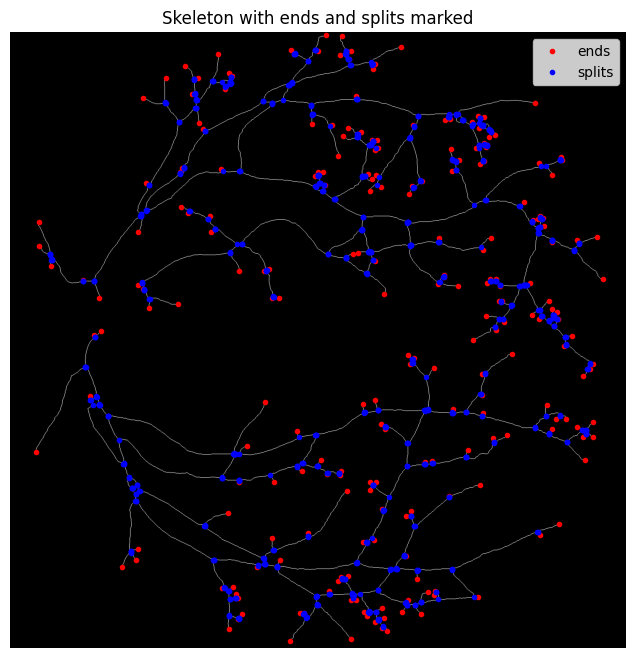

In [10]:
retina_skeleton_ends = get_ends(retina_skeleton)
retina_skeleton_splits = get_splits(retina_skeleton)

print(f"Końcówki: {np.sum(retina_skeleton_ends)}")
print(f"Rozgałęzienia: {np.sum(retina_skeleton_splits)}")

plt.figure(figsize = (8,8))
plt.imshow(retina_skeleton, cmap="gray")
for points, label, color in zip([retina_skeleton_ends, retina_skeleton_splits], ["ends", "splits"], ["red", "blue"]):
    ys, xs = np.where(points)
    plt.plot(xs, ys, label=label, color=color, linestyle="", marker=".")
plt.axis("off")
plt.title("Skeleton with ends and splits marked")
plt.legend()
plt.show()